In [1]:
# Define critical control variables

# Min/max values used to scale the height, lon, and lat
scale_minimum = 0
scale_maximum = 1

In [2]:
# Common imports
import os
from pathlib import Path

import numpy as np
import pandas as pd

from datetime import datetime

In [3]:
# Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [4]:
# Data pipeline, scaling, normalizing, etc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


In [5]:
# Import functions from the utilities file
from TZVOLCANO_utilities import *

# Early version of chords GUI interface
from chords_gui import chords_gui 

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [ ]:
# KMeans import

from sklearn.cluster import KMeans

In [6]:
# Render the data download widget
domain = 'tzvolcano.chordsrt.com'
chords = chords_gui(domain)

# Define the initial start and end date for the date selector
start_date_string = '2021-01-01'
end_date_string = '2021-01-05'

# Generate the uer interface
chords.start_end_widgets(start_date_string, end_date_string)

Output()

In [7]:
chords.select_data_file()

Available Data Files


Output()

In [8]:
# Read contents of the selected file in to a pandas object
file_name = chords.available_data_files.value
print("Imported csv dat from" + file_name)

unmodified_data = chords.load_data_from_file(file_name)

Imported csv dat fromtzvolcano_chordsrt_com_instrument_id_1_2021-01-01_to_2021-01-01.csv
csv_files/tzvolcano_chordsrt_com_instrument_id_1_2021-01-01_to_2021-01-01.csv


In [29]:
# Fill in missing points in the time series
resampled_data = unmodified_data.copy()

# resampled_data = resampled_data.set_index('Time').sort_index().resample('1000ms').ffill()

# Re-insert the 'Time' field, as the resampling process changed it to be the index
# resampled_data['Time'] = resampled_data.index



In [30]:
# Rescale Height, Longitude and Latitude to the range between scale_minimum and scale_maximum
scaled_data = pd.DataFrame()

# Convert the Time variable to Seconds Since Epoch
scaled_data["Seconds Since Epoch"] = resampled_data['Time'].astype(np.int64)
# scaled_data["Time"] = resampled_data['Time']

scaled_data["Scaled Height"] = scale_np_data(resampled_data["Height"].to_numpy(), scale_minimum, scale_maximum)
scaled_data["Scaled Latitude"] = scale_np_data(resampled_data["Latitude"].to_numpy(), scale_minimum, scale_maximum)
scaled_data["Scaled Longitude"] = scale_np_data(resampled_data["Longitude"].to_numpy(), scale_minimum, scale_maximum)

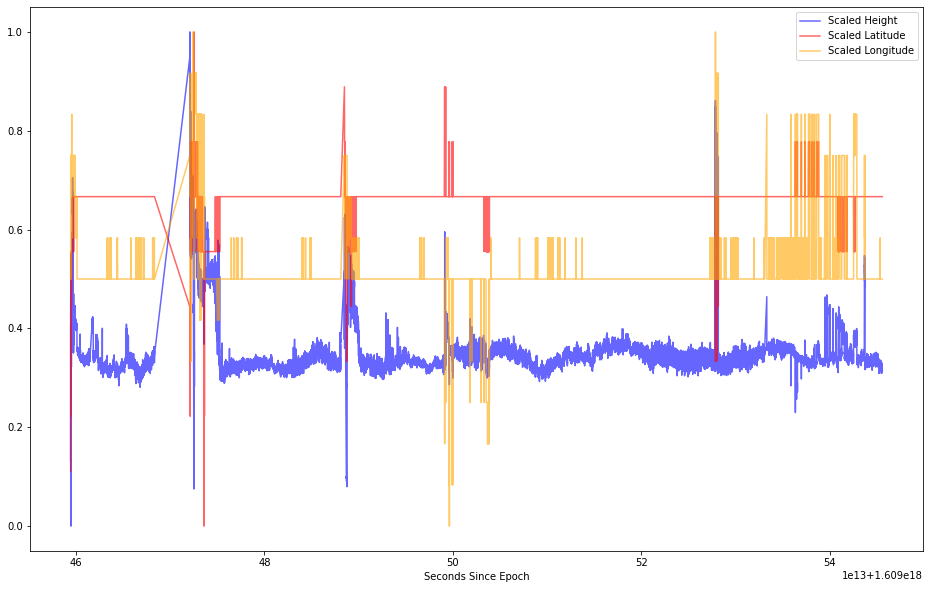

In [31]:
plt.figure(figsize=(16, 10))

# get current axis
ax = plt.gca()
alpha = 0.6

scaled_data.plot(kind='line',x='Seconds Since Epoch',y='Scaled Height', color='blue',ax=ax, alpha=alpha)
scaled_data.plot(kind='line',x='Seconds Since Epoch',y='Scaled Latitude', color='red', ax=ax, alpha=alpha)
scaled_data.plot(kind='line',x='Seconds Since Epoch',y='Scaled Longitude', color='orange', ax=ax, alpha=alpha)

plt.show()

In [32]:
# Treating the individual fields as a vector, calculate the scalar value as a derived feature
fields_list = ['Scaled Height', 'Scaled Latitude', 'Scaled Longitude']

scaled_data["Average Scalar"] = calculate_scalar(scaled_data, fields_list, scale_minimum, scale_maximum)

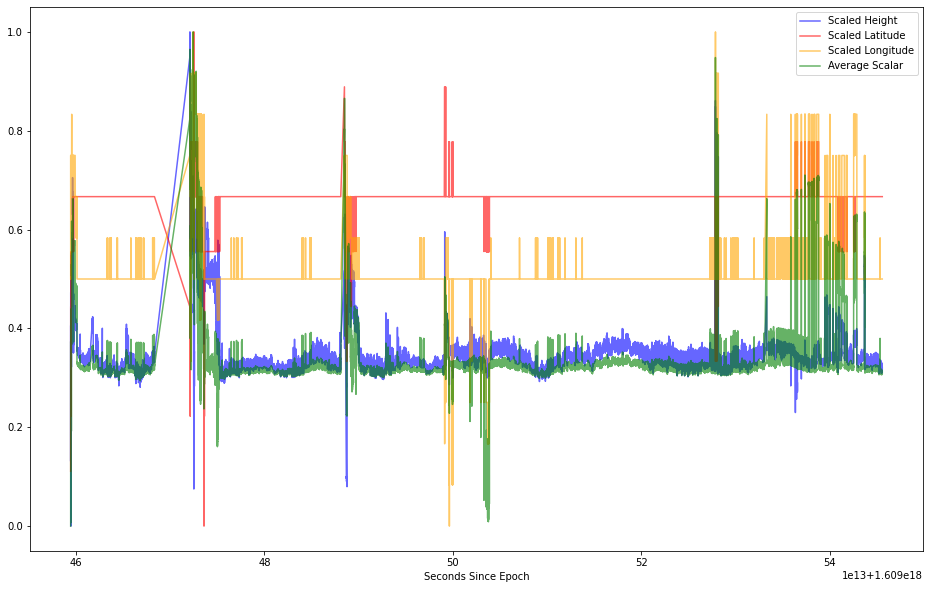

In [33]:
plt.figure(figsize=(16, 10))

# get current axis
ax = plt.gca()
alpha = 0.6

scaled_data.plot(kind='line',x='Seconds Since Epoch',y='Scaled Height', color='blue',ax=ax, alpha=alpha)
scaled_data.plot(kind='line',x='Seconds Since Epoch',y='Scaled Latitude', color='red', ax=ax, alpha=alpha)
scaled_data.plot(kind='line',x='Seconds Since Epoch',y='Scaled Longitude', color='orange', ax=ax, alpha=alpha)

scaled_data.plot(kind='line',x='Seconds Since Epoch',y='Average Scalar', color='green', ax=ax, alpha=alpha)

plt.show()

In [34]:
scalar_data = scaled_data.drop(["Scaled Longitude", "Scaled Latitude", "Scaled Height"], axis=1)

scalar_data.keys()

Index(['Seconds Since Epoch', 'Average Scalar'], dtype='object')

In [35]:
# Define a pipline to clean numerical data
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent")),
])

# Test that the pipeline works
scalar_data_imputed = num_pipeline.fit_transform(scalar_data)

scalar_data_imputed

array([[1.60945943e+18, 0.00000000e+00],
       [1.60945943e+18, 8.06914679e-02],
       [1.60945944e+18, 8.11127876e-02],
       ...,
       [1.60954559e+18, 3.07886754e-01],
       [1.60954559e+18, 3.10037907e-01],
       [1.60954560e+18, 3.11396556e-01]])

In [36]:
from sklearn.cluster import KMeans


In [37]:
k = 16
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(scalar_data_imputed)

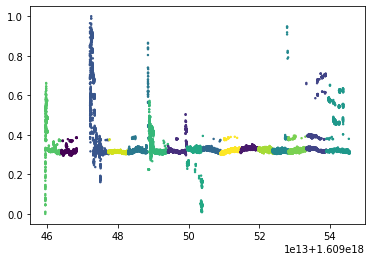

In [38]:
# Useful K-means article
# https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
plt.scatter(scalar_data_imputed[:, 0], scalar_data_imputed[:, 1], c=y_pred,
            s=2, cmap='viridis');

In [39]:
y_pred is kmeans.labels_

True

In [40]:
kmeans.cluster_centers_

array([[1.60946660e+18, 3.14246785e-01],
       [1.60951778e+18, 3.31794732e-01],
       [1.60949709e+18, 3.22979005e-01],
       [1.60953575e+18, 3.95717022e-01],
       [1.60947495e+18, 4.05256168e-01],
       [1.60950632e+18, 3.25487390e-01],
       [1.60948600e+18, 3.25922392e-01],
       [1.60952587e+18, 3.21485510e-01],
       [1.60954224e+18, 4.04084257e-01],
       [1.60950204e+18, 3.06464838e-01],
       [1.60949127e+18, 3.33000455e-01],
       [1.60946149e+18, 3.53062033e-01],
       [1.60953072e+18, 3.22255013e-01],
       [1.60952184e+18, 3.23424111e-01],
       [1.60947979e+18, 3.13407009e-01],
       [1.60951180e+18, 3.18443274e-01]])

In [41]:
kmeans.labels_


array([11, 11, 11, ...,  8,  8,  8], dtype=int32)

In [42]:
X = scalar_data_imputed

In [43]:
print(type(scalar_data))
print(type(scalar_data_imputed))
print(type(X))


<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


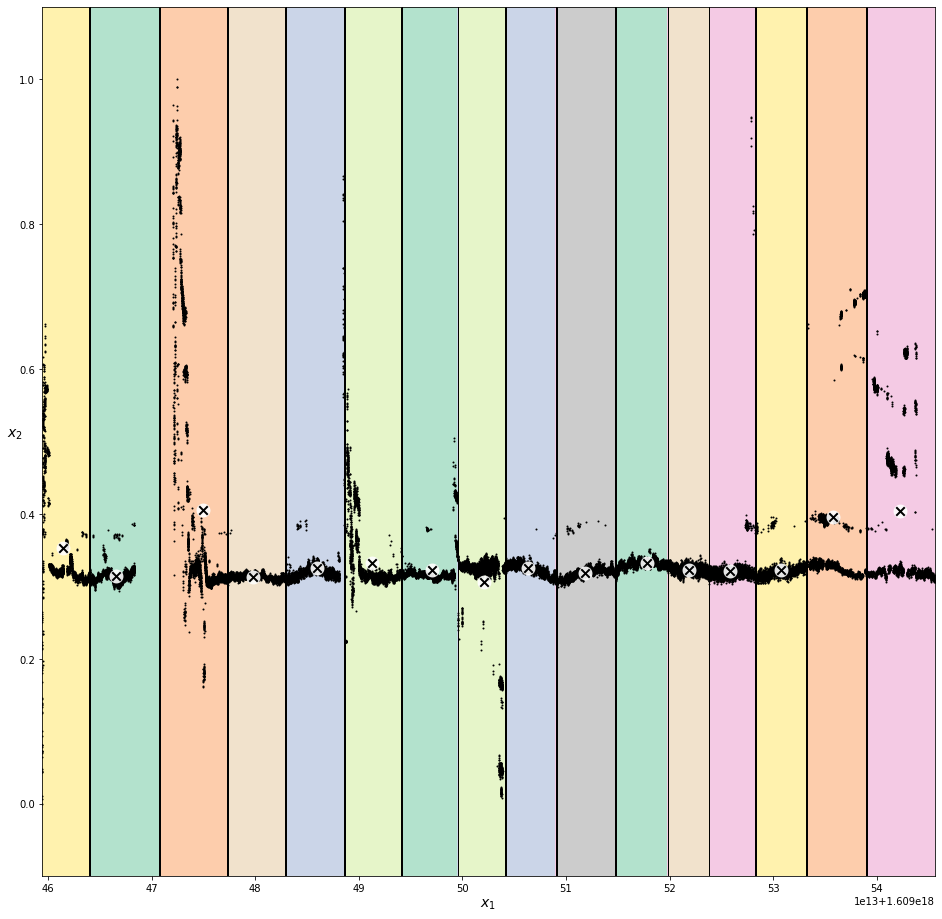

In [44]:
plt.figure(figsize=(16, 16))

plot_decision_boundaries(kmeans, scalar_data_imputed)

plt.show()